In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Aug 17 16:43:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    64W / 300W |   8039MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [4]:
n_mels = 80
n_outputs = 61
n_frames = 400

### Model

In [5]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256, dilation_rate=2)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
print('done')

done


### Load

In [7]:
save_dir = '/data/scpark/save/lips/train08.17-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 140000, model, None, optimizer)

total 0
-rw-rw-r-- 1 scpark scpark 0  8월 17 16:43 events.out.tfevents.1692258234.GPUSVR11


### Dataset

In [8]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [9]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [10]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    

test : 0 -3.1052355766296387
test : 1 -3.3625235557556152
test : 2 -3.3385653495788574
test : 3 -3.2206478118896484
test : 4 -3.299625873565674
test : 5 -3.2977447509765625
test : 6 -3.197082996368408
test : 7 -3.2024636268615723
test : 8 -3.382444381713867
test : 9 -3.2435622215270996
test_loss : -3.2649896144866943


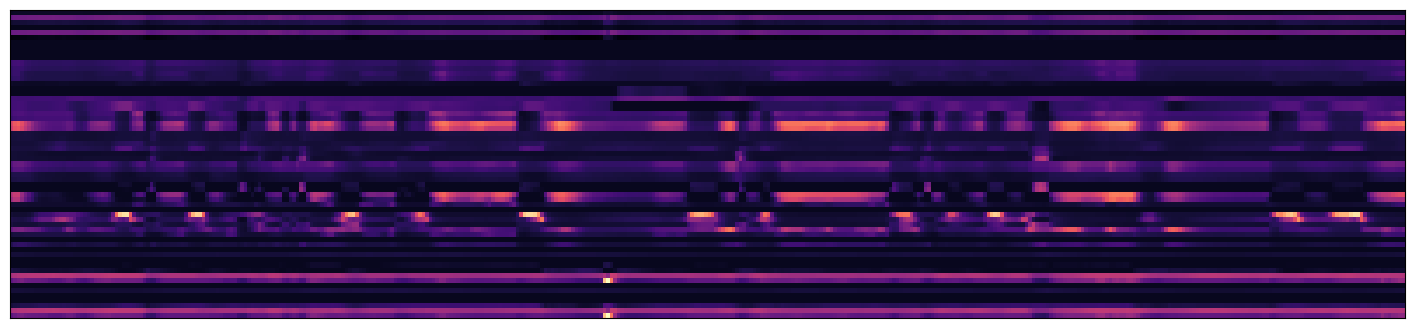

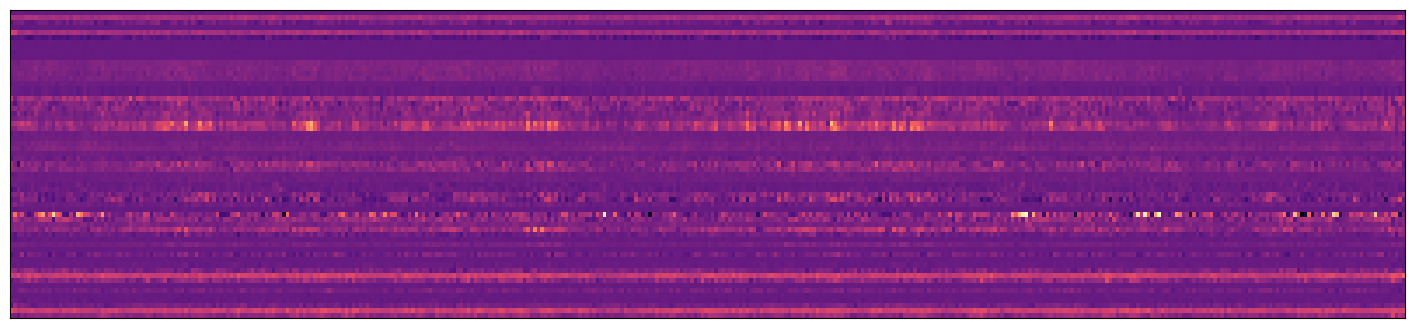

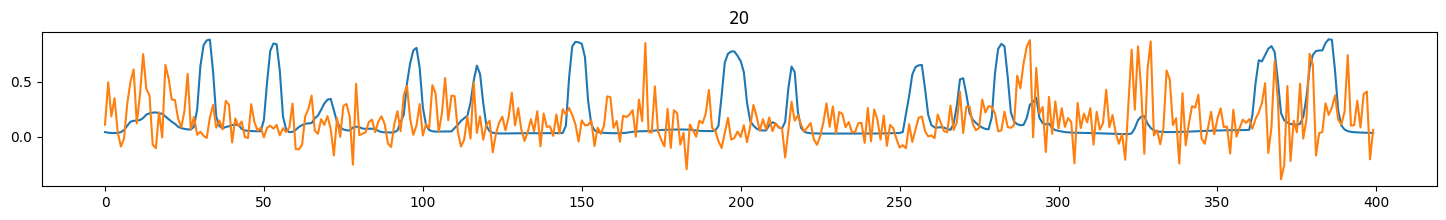

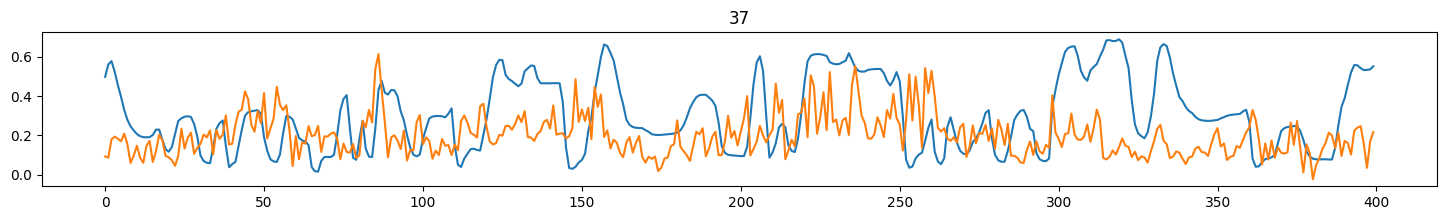

1001
loss -3.2921695709228516
1001 -3.2921695709228516
1002
loss -3.1441102027893066
1002 -3.1441102027893066
1003
loss -3.125814914703369
1003 -3.125814914703369
1004
loss -3.1748433113098145
1004 -3.1748433113098145
1005
loss -3.1751861572265625
1005 -3.1751861572265625
1006
loss -3.172513484954834
1006 -3.172513484954834
1007
loss -3.3272085189819336
1007 -3.3272085189819336
1008
loss -3.173623561859131
1008 -3.173623561859131
1009
loss -3.1549010276794434
1009 -3.1549010276794434
1010
loss -3.1937074661254883
1010 -3.1937074661254883
1011
loss -3.319270133972168
1011 -3.319270133972168
1012
loss -3.2865238189697266
1012 -3.2865238189697266
1013
loss -3.2714734077453613
1013 -3.2714734077453613
1014
loss -3.1766343116760254
1014 -3.1766343116760254
1015
loss -3.2755494117736816
1015 -3.2755494117736816
1016
loss -3.2096705436706543
1016 -3.2096705436706543
1017
loss -3.1111717224121094
1017 -3.1111717224121094
1018
loss -3.1653194427490234
1018 -3.1653194427490234
1019
loss -3.22336

1153
loss -3.135371208190918
1153 -3.135371208190918
1154
loss -3.2683820724487305
1154 -3.2683820724487305
1155
loss -3.172651767730713
1155 -3.172651767730713
1156
loss -3.274196147918701
1156 -3.274196147918701
1157
loss -3.3313088417053223
1157 -3.3313088417053223
1158
loss -3.3597917556762695
1158 -3.3597917556762695
1159
loss -3.269789218902588
1159 -3.269789218902588
1160
loss -3.305996894836426
1160 -3.305996894836426
1161
loss -3.320283889770508
1161 -3.320283889770508
1162
loss -3.336261749267578
1162 -3.336261749267578
1163
loss -3.34663724899292
1163 -3.34663724899292
1164
loss -3.3024168014526367
1164 -3.3024168014526367
1165
loss -3.35081148147583
1165 -3.35081148147583
1166
loss -3.2174696922302246
1166 -3.2174696922302246
1167
loss -3.2883033752441406
1167 -3.2883033752441406
1168
loss -3.3754701614379883
1168 -3.3754701614379883
1169
loss -3.227405071258545
1169 -3.227405071258545
1170
loss -3.243467330932617
1170 -3.243467330932617
1171
loss -3.25100040435791
1171 -3.

1305
loss -3.1633100509643555
1305 -3.1633100509643555
1306
loss -3.091801643371582
1306 -3.091801643371582
1307
loss -2.8676705360412598
1307 -2.8676705360412598
1308
loss -3.1725993156433105
1308 -3.1725993156433105
1309
loss -3.3029346466064453
1309 -3.3029346466064453
1310
loss -3.166693687438965
1310 -3.166693687438965
1311
loss -3.2199740409851074
1311 -3.2199740409851074
1312
loss -3.1251401901245117
1312 -3.1251401901245117
1313
loss -3.2285075187683105
1313 -3.2285075187683105
1314
loss -3.325368881225586
1314 -3.325368881225586
1315
loss -3.304509162902832
1315 -3.304509162902832
1316
loss -3.283039093017578
1316 -3.283039093017578
1317
loss -3.270185947418213
1317 -3.270185947418213
1318
loss -3.3437695503234863
1318 -3.3437695503234863
1319
loss -3.363953113555908
1319 -3.363953113555908
1320
loss -3.325925350189209
1320 -3.325925350189209
1321
loss -3.4093003273010254
1321 -3.4093003273010254
1322
loss -3.3863391876220703
1322 -3.3863391876220703
1323
loss -3.3172054290771

1456 -3.437201976776123
1457
loss -3.383395195007324
1457 -3.383395195007324
1458
loss -3.4510135650634766
1458 -3.4510135650634766
1459
loss -3.4290647506713867
1459 -3.4290647506713867
1460
loss -3.3739452362060547
1460 -3.3739452362060547
1461
loss -3.272336483001709
1461 -3.272336483001709
1462
loss -3.3146519660949707
1462 -3.3146519660949707
1463
loss -3.4149270057678223
1463 -3.4149270057678223
1464
loss -3.2162280082702637
1464 -3.2162280082702637
1465
loss -3.4226746559143066
1465 -3.4226746559143066
1466
loss -3.4652185440063477
1466 -3.4652185440063477
1467
loss -3.524932384490967
1467 -3.524932384490967
1468
loss -3.4605793952941895
1468 -3.4605793952941895
1469
loss -3.442925453186035
1469 -3.442925453186035
1470
loss -3.5075011253356934
1470 -3.5075011253356934
1471
loss -3.4545040130615234
1471 -3.4545040130615234
1472
loss -3.529254913330078
1472 -3.529254913330078
1473
loss -3.4518446922302246
1473 -3.4518446922302246
1474
loss -3.5245819091796875
1474 -3.5245819091796

1608 -3.5127601623535156
1609
loss -3.449979305267334
1609 -3.449979305267334
1610
loss -3.5869150161743164
1610 -3.5869150161743164
1611
loss -3.539328098297119
1611 -3.539328098297119
1612
loss -3.382145881652832
1612 -3.382145881652832
1613
loss -3.0886621475219727
1613 -3.0886621475219727
1614
loss -2.8382787704467773
1614 -2.8382787704467773
1615
loss -2.9775476455688477
1615 -2.9775476455688477
1616
loss -3.3324074745178223
1616 -3.3324074745178223
1617
loss -3.2305216789245605
1617 -3.2305216789245605
1618
loss -3.333704948425293
1618 -3.333704948425293
1619
loss -3.198005199432373
1619 -3.198005199432373
1620
loss -3.2548561096191406
1620 -3.2548561096191406
1621
loss -3.3206896781921387
1621 -3.3206896781921387
1622
loss -3.204296112060547
1622 -3.204296112060547
1623
loss -3.353628635406494
1623 -3.353628635406494
1624
loss -3.427743911743164
1624 -3.427743911743164
1625
loss -3.3348097801208496
1625 -3.3348097801208496
1626
loss -3.3892946243286133
1626 -3.3892946243286133
1

1760 -3.6595168113708496
1761
loss -3.464933395385742
1761 -3.464933395385742
1762
loss -3.4776806831359863
1762 -3.4776806831359863
1763
loss -3.5755577087402344
1763 -3.5755577087402344
1764
loss -3.4983463287353516
1764 -3.4983463287353516
1765
loss -3.549184799194336
1765 -3.549184799194336
1766
loss -3.4253249168395996
1766 -3.4253249168395996
1767
loss -3.487565040588379
1767 -3.487565040588379
1768
loss -3.602799892425537
1768 -3.602799892425537
1769
loss -3.5777225494384766
1769 -3.5777225494384766
1770
loss -3.4769792556762695
1770 -3.4769792556762695
1771
loss -3.4831743240356445
1771 -3.4831743240356445
1772
loss -3.474803924560547
1772 -3.474803924560547
1773
loss -3.096299171447754
1773 -3.096299171447754
1774
loss -3.467123508453369
1774 -3.467123508453369
1775
loss -3.2158689498901367
1775 -3.2158689498901367
1776
loss -3.588636875152588
1776 -3.588636875152588
1777
loss -3.3775172233581543
1777 -3.3775172233581543
1778
loss -3.51348876953125
1778 -3.51348876953125
1779


1912 -3.591464042663574
1913
loss -3.629115581512451
1913 -3.629115581512451
1914
loss -3.5715012550354004
1914 -3.5715012550354004
1915
loss -3.5535078048706055
1915 -3.5535078048706055
1916
loss -3.6122379302978516
1916 -3.6122379302978516
1917
loss -3.725862503051758
1917 -3.725862503051758
1918
loss -3.7149271965026855
1918 -3.7149271965026855
1919
loss -3.5384521484375
1919 -3.5384521484375
1920
loss -3.6435294151306152
1920 -3.6435294151306152
1921
loss -3.587649345397949
1921 -3.587649345397949
1922
loss -3.526991367340088
1922 -3.526991367340088
1923
loss -3.52451229095459
1923 -3.52451229095459
1924
loss -3.404083251953125
1924 -3.404083251953125
1925
loss -3.529691219329834
1925 -3.529691219329834
1926
loss -3.622417449951172
1926 -3.622417449951172
1927
loss -3.544485092163086
1927 -3.544485092163086
1928
loss -3.473003387451172
1928 -3.473003387451172
1929
loss -3.5841550827026367
1929 -3.5841550827026367
1930
loss -3.4508719444274902
1930 -3.4508719444274902
1931
loss -3.4

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)